In [397]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from matplotlib import dates
from scipy.optimize import curve_fit
from scipy.stats import multivariate_normal

# Part A:

In [128]:
data = pd.read_csv("dataexport_20230913T204319.csv")

C:\Users\Sarah\AppData\Local\Temp\ipykernel_5032\2504283423.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("dataexport_20230913T204319.csv")


In [395]:
data[0:11]

,location,Basel,Basel.1,Basel.2,Basel.3,Basel.4,Basel.5,Basel.6,Basel.7,Basel.8,...,Basel.53,Basel.54,Basel.55,Basel.56,Basel.57,Basel.58,Basel.59,Basel.60,Basel.61,Basel.62
0,lat,47.75000,47.75000,47.75000,47.75000,47.75000,47.75000,47.75000,47.75000,47.75000,...,47.75000,47.75000,47.75000,47.75000,47.75000,47.75000,47.75000,47.75000,47.75000,47.75000
1,lon,7.50000,7.50000,7.50000,7.50000,7.50000,7.50000,7.50000,7.50000,7.50000,...,7.50000,7.50000,7.50000,7.50000,7.50000,7.50000,7.50000,7.50000,7.50000,7.50000
2,asl,363.653,363.653,363.653,363.653,363.653,363.653,363.653,363.653,363.653,...,363.653,363.653,363.653,363.653,363.653,363.653,363.653,363.653,363.653,363.653
3,variable,Temperature,Growing Degree Days,Temperature,Temperature,Temperature,Temperature,Temperature,Precipitation Total,Relative Humidity,...,Soil Temperature,Soil Temperature,Soil Moisture,Soil Moisture,Soil Moisture,Soil Moisture,Soil Moisture Available To Plant,Soil Moisture Available To Plant,Soil Moisture Available To Plant,Soil Moisture Available To Plant
4,unit,°F,GDDf,°F,°F,°F,°F,°F,mm,%,...,°F,°F,m³/m³,m³/m³,m³/m³,m³/m³,fraction,fraction,fraction,fraction
5,level,2 m elevation corrected,2 m elevation corrected,900 mb,850 mb,800 mb,700 mb,500 mb,sfc,2 m,...,28-100 cm down,100-255 cm down,0-7 cm down,7-28 cm down,28-100 cm down,100-255 cm down,0-7 cm down,7-28 cm down,28-100 cm down,100-255 cm down
6,resolution,hourly,hourly,hourly,hourly,hourly,hourly,hourly,hourly,hourly,...,hourly,hourly,hourly,hourly,hourly,hourly,hourly,hourly,hourly,hourly
7,aggregation,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
8,timestamp,Basel Temperature [2 m elevation corrected],Basel Growing Degree Days [2 m elevation corre...,Basel Temperature [900 mb],Basel Temperature [850 mb],Basel Temperature [800 mb],Basel Temperature [700 mb],Basel Temperature [500 mb],Basel Precipitation Total,Basel Relative Humidity [2 m],...,Basel Soil Temperature [28-100 cm down],Basel Soil Temperature [100-255 cm down],Basel Soil Moisture [0-7 cm down],Basel Soil Moisture [7-28 cm down],Basel Soil Moisture [28-100 cm down],Basel Soil Moisture [100-255 cm down],Basel Soil Moisture Available To Plant [0-7 cm...,Basel Soil Moisture Available To Plant [7-28 c...,Basel Soil Moisture Available To Plant [28-100...,Basel Soil Moisture Available To Plant [100-25...
9,20220101T0000,43.68244,0.8333333,52.322,50.63,44.978,34.232,3.2180004,0.0,93.82894,...,42.926,45.59,0.392,0.405,0.397,0.349,0.241,0.254,0.24600002,0.19800001


Ok, it looks like the columns in this data set are different detectors in Basel Switzerland. Then, the first 8 rows are information about each specific detector (it's elevation, what it measures, etc). The rest of the rows are entries from all the detectors on a specific date and time (listed in the first column), with each detector's corresponding measurement in their column.

It looks like the overall Basel Temperature (corrected) is in column 2 (name Basel) and the timestamp is in column 1 (name location) starting in row 10 (index 9)

In [131]:
data_data = data[9:14723] #rows containing actual data
temps = data_data["Basel"].values #pull out temperature strings
times = data_data["location"].values #pull out datetime strings

In [340]:
#create datetime objects for all of the datetime strings
timestamps = []
for i in range(len(data_data)):
    d  = dt.datetime.strptime(times[i], "%Y%m%dT%H%M")
    timestamps.append(d)
timestamps = np.array(timestamps)
    
#change all temperatures into floats
temp = []
for i in range(len(data_data)):
    temp.append(float(temps[i]))
temp = np.array(temp)

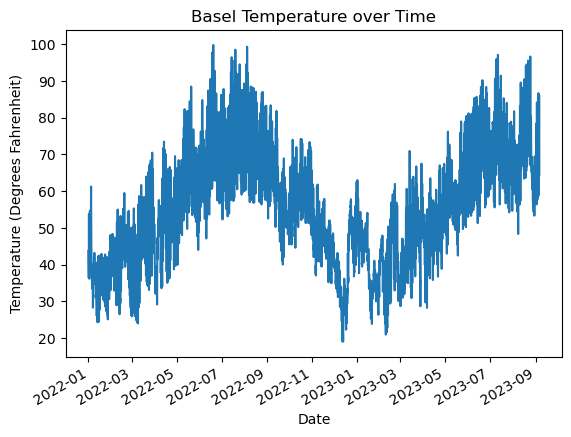

In [341]:
#plot the temperature vs datetime
plt.figure()
plt.plot(timestamps, temp)
plt.title("Basel Temperature over Time")
plt.ylabel("Temperature (Degrees Fahrenheit)")
plt.xlabel("Date")
plt.gcf().autofmt_xdate() #makes labels not overlap

In [342]:
#define function to fit the data to
def f(t,a,b,c,d,e):
    return (a*np.sin((b*t)+c))+(d*t)+e

In [347]:
#use the .timestamp() function to make all the timestamps into a float np.array to use in the model fitting
ft = []
for i in range(len(timestamps)):
    ft.append(timestamps[i].timestamp())
float_times = np.array(ft)

In [344]:
#use curve_fit to fit my function to the data
#initially guess an amplitude ~40, frequency~1e-8, (just chose random numbers for the rest)
coefs, covariance = curve_fit(f, float_times, temp, [40,1e-8,3,10,2,])
model = (coefs[0]*np.sin((coefs[1]*float_times)+coefs[2])) + (coefs[3]*float_times) + coefs[4]

In [345]:
np.diag(covariance)

array([1.07653858e-02, 2.93535181e-19, 8.16503314e-01, 3.62437561e-17,
       1.00864989e+02])

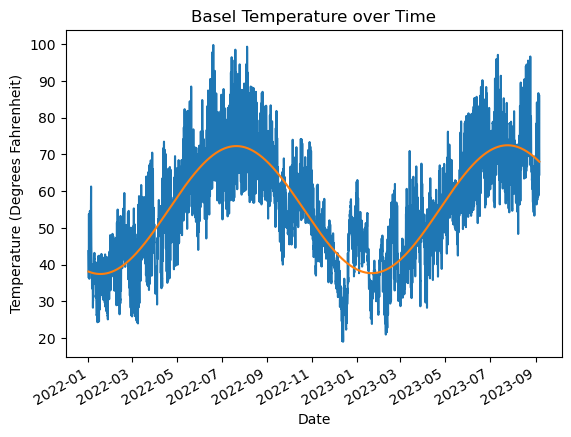

In [346]:
#plot the temperature vs datetime and the model
plt.figure()
plt.plot(timestamps, temp)
plt.title("Basel Temperature over Time")
plt.ylabel("Temperature (Degrees Fahrenheit)")
plt.xlabel("Date")
plt.plot(timestamps, model)
plt.gcf().autofmt_xdate() #makes labels not overlap

In [407]:
b = coefs[1]
d = coefs[3]
sigmab = np.sqrt(covariance[1,1])
sigmad = np.sqrt(covariance[3,3])
sigma_bd2 = covariance[1,3]

In [408]:
bs = np.linspace(b-sigmab, b+sigmab, 1000)
ds = np.linspace(d-sigmad, d+sigmad, 1000)
B, D = np.meshgrid(bs, ds)

In [409]:
array1 = np.empty(B.shape + (2,)) #create 3D array in order to plot the contour
array1[:,:,0] = B
array1[:,:,1] = D
dist = multivariate_normal([b,d], [[sigmab**2, sigma_bd2], [sigma_bd2, sigmad**2]])

Text(0.5, 1.0, '1σ Two-Dimensional χ2 Confidence Contour')

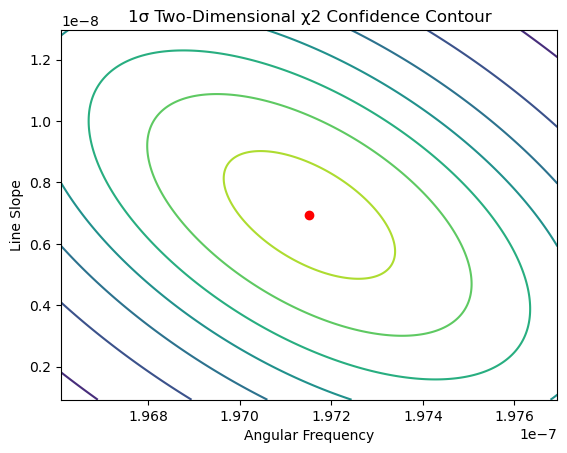

In [416]:
plt.contour(B,D,dist.pdf(array1))
plt.scatter(b,d, color="r")
plt.xlabel("Angular Frequency")
plt.ylabel("Line Slope")
plt.title("1σ Two-Dimensional χ2 Confidence Contour")

Since this contour map is not circular (instead it's elliptical), there is a relationship between line slope and angular frequency. Specifically, since the ellipse is slanted left, there is a negative relationship between the 2 parameters.

# Part B:

In [327]:
snow = data_data["Basel.9"].values #pull out Snowfall Amount strings
cloud = data_data["Basel.31"].values #pull out Cloud Cover Low strings
wind = data_data["Basel.13"].values #pull out Basel Wind Direction [10m] strings
pressure = data_data["Basel.39"].values #pull out Mean Sea Level Pressure strings

In [336]:
#create np.arrays containing the float values of all 4 variables
snow_fall = []
cloud_cover = []
wind_direction = []
MSL_pressure = []
for i in range(len(data_data)):
    snow_fall.append(float(snow[i]))
    cloud_cover.append(float(cloud[i]))
    wind_direction.append(float(wind[i]))
    MSL_pressure.append(float(pressure[i]))
    
snowfall = np.array(snow_fall)
cloud_cover = np.array(cloud_cover)
wind_direction = np.array(wind_direction)
MSL_pressure = np.array(MSL_pressure)

In [299]:
#find the rows in which the snowfall is larger than 0 (aka, it's snowing)
snow_inds = np.where(snowfall>0)
snow_inds = snow_inds[0]

In [387]:
#find the rows in which the snowfall is the first hour (onset) of snow
snow_onset_inds = []
snow_onset_inds.append(snow_inds[0]) #add the first time it snows in the snow_inds list 

#check if the index is the first snow (onset) or if it's within a larger time-chunk of snow
for i in range(1, len(snow_inds)):
    #check if the previously snow-identified index was the previous hour
    if(snow_inds[i]-1 == snow_inds[i-1]):
        continue
    else:
        #if the previous snow_index was not the previous hour, this index counts as a snow-onset
        snow_onset_inds.append(snow_inds[i])

In [388]:
#create an array containing the indexes of the previous 6 hours for every snow-onset
before_inds = []
for i in range(len(snow_onset_inds)):
    
    start_ind = snow_onset_inds[i] - 6
    n = np.arange(start_ind, snow_onset_inds[i])
    before_inds.append(n)
    
before_inds = np.array(before_inds)

In [420]:
before_inds.shape

(40, 6)

In [348]:
#create arrays for all relevant variables containing the datapoints 6 hours before each snow-onset
before_cloud = cloud_cover[before_inds]
before_wind = wind_direction[before_inds]
before_pressure = MSL_pressure[before_inds]
before_temp = temp[before_inds]

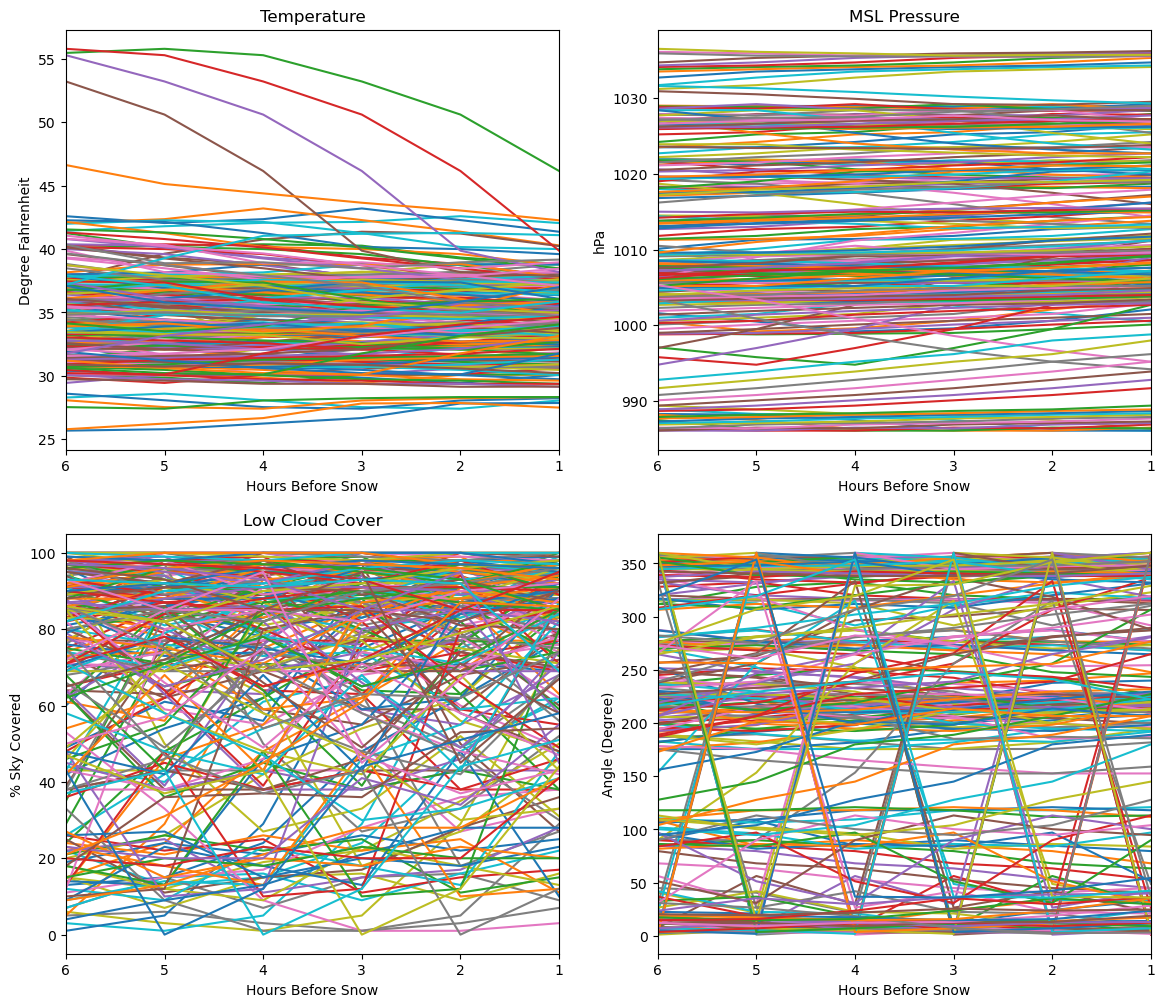

In [390]:
hours = [6,5,4,3,2,1] #create array of number of hours until snow-onset

#plot the preceeding 6 hours before snow-onset of 4 variables: temp, MSL pressure, cloud cover, wind direction
plt.figure(figsize=(14,12))
plt.subplot(221)
plt.title("Temperature")
plt.ylabel("Degree Fahrenheit")
plt.xlabel("Hours Before Snow")
plt.xlim(6,1)
plt.subplot(222)
plt.title("MSL Pressure")
plt.ylabel("hPa")
plt.xlabel("Hours Before Snow")
plt.xlim(6,1)
plt.subplot(223)
plt.title("Low Cloud Cover")
plt.ylabel("% Sky Covered")
plt.xlabel("Hours Before Snow")
plt.xlim(6,1)
plt.subplot(224)
plt.title("Wind Direction")
plt.ylabel("Angle (Degree)")
plt.xlabel("Hours Before Snow")
plt.xlim(6,1)

for i in range(len(before_cloud)):
    plt.subplot(221)
    plt.plot(hours, before_temp[i])
    
    plt.subplot(222)
    plt.plot(hours, before_pressure[i])
    
    plt.subplot(223)
    plt.plot(hours, before_cloud[i])
    
    plt.subplot(224)
    plt.plot(hours, before_wind[i])
    
plt.show()

In [376]:
#find the mean values for each variable at each hour before snow-onset
mean_cloud = np.mean(before_cloud, 0)
mean_wind = np.mean(before_wind, 0)
mean_pressure = np.mean(before_pressure, 0)
mean_temp = np.mean(before_temp, 0)

(6.0, 1.0)

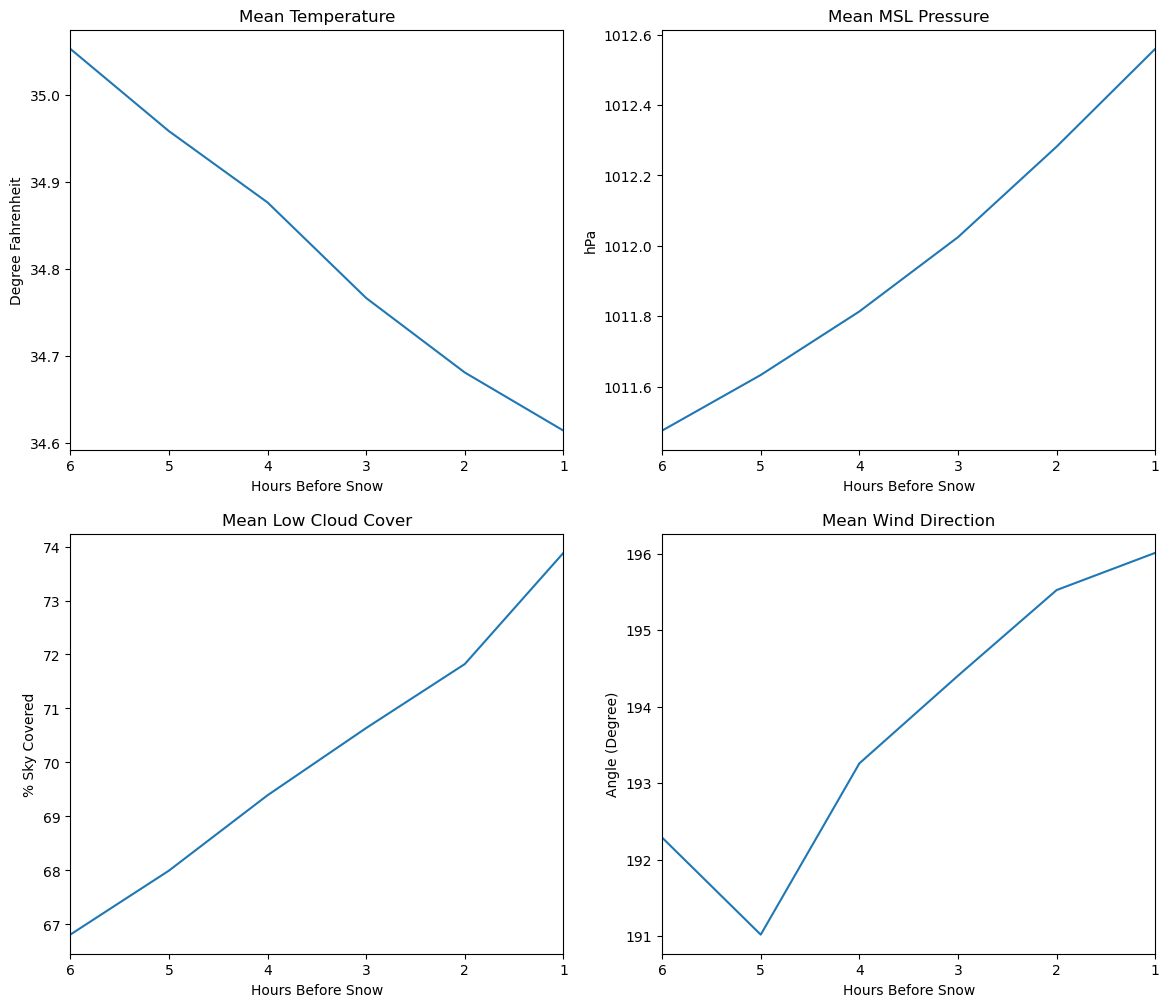

In [391]:
#plot the mean temp, MSL pressure, cloud cover, and wind direction in the 6 hours before a snow-onset
plt.figure(figsize=(14,12))
plt.subplot(221)
plt.title("Mean Temperature")
plt.ylabel("Degree Fahrenheit")
plt.xlabel("Hours Before Snow")
plt.plot(hours, mean_temp)
plt.xlim(6,1)

plt.subplot(222)
plt.title("Mean MSL Pressure")
plt.ylabel("hPa")
plt.xlabel("Hours Before Snow")
plt.plot(hours, mean_pressure)
plt.xlim(6,1)

plt.subplot(223)
plt.title("Mean Low Cloud Cover")
plt.ylabel("% Sky Covered")
plt.xlabel("Hours Before Snow")
plt.plot(hours, mean_cloud)
plt.xlim(6,1)

plt.subplot(224)
plt.title("Mean Wind Direction")
plt.ylabel("Angle (Degree)")
plt.xlabel("Hours Before Snow")
plt.plot(hours, mean_wind)
plt.xlim(6,1)

In [417]:
#find the mean values for each variable at each hour before snow-onset
median_cloud = np.median(before_cloud, 0)
median_wind = np.median(before_wind, 0)
median_pressure = np.median(before_pressure, 0)
median_temp = np.median(before_temp, 0)

(6.0, 1.0)

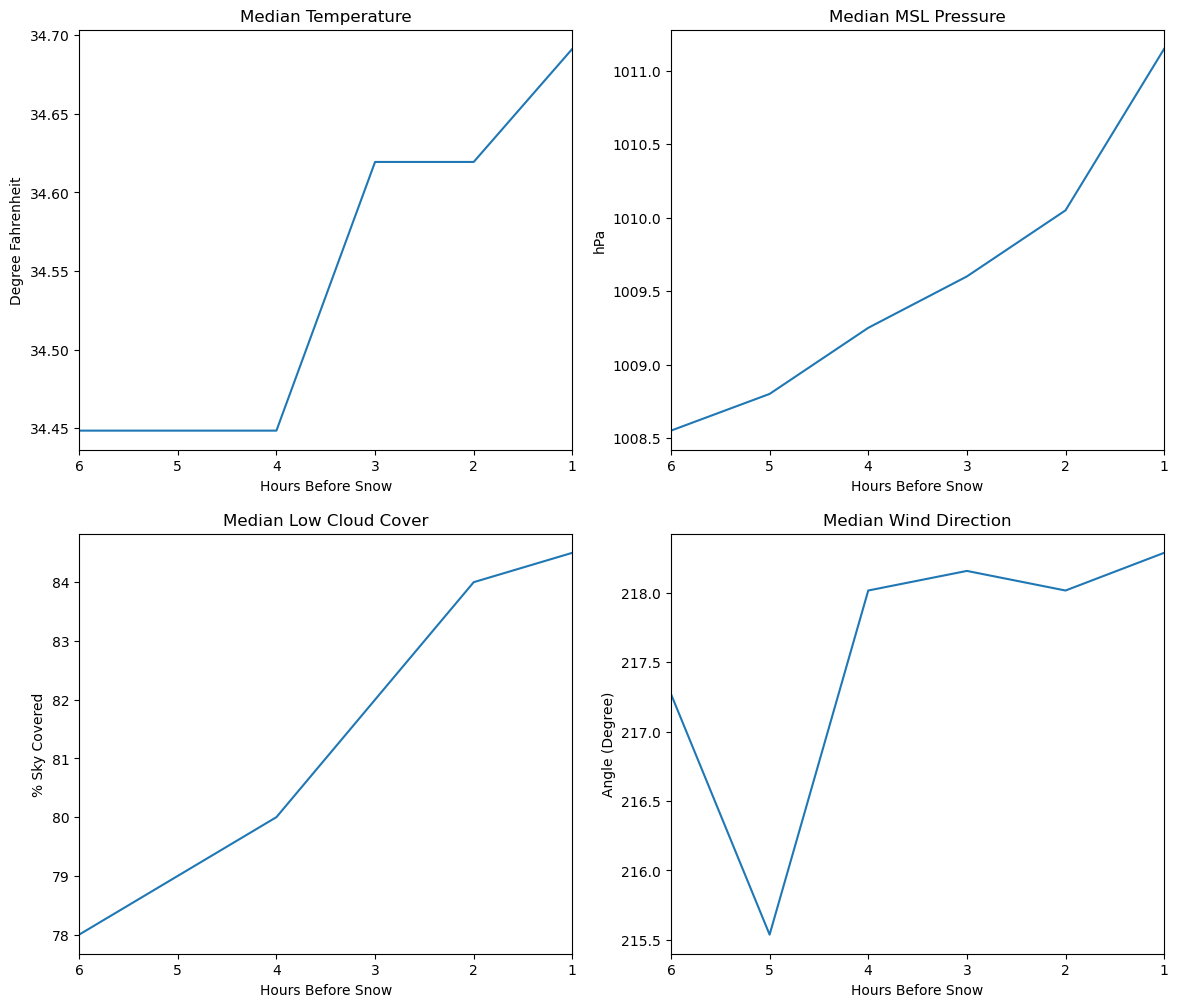

In [418]:
#plot the median temp, MSL pressure, cloud cover, and wind direction in the 6 hours before a snow-onset
plt.figure(figsize=(14,12))
plt.subplot(221)
plt.title("Median Temperature")
plt.ylabel("Degree Fahrenheit")
plt.xlabel("Hours Before Snow")
plt.plot(hours, median_temp)
plt.xlim(6,1)

plt.subplot(222)
plt.title("Median MSL Pressure")
plt.ylabel("hPa")
plt.xlabel("Hours Before Snow")
plt.plot(hours, median_pressure)
plt.xlim(6,1)

plt.subplot(223)
plt.title("Median Low Cloud Cover")
plt.ylabel("% Sky Covered")
plt.xlabel("Hours Before Snow")
plt.plot(hours, median_cloud)
plt.xlim(6,1)

plt.subplot(224)
plt.title("Median Wind Direction")
plt.ylabel("Angle (Degree)")
plt.xlabel("Hours Before Snow")
plt.plot(hours, median_wind)
plt.xlim(6,1)

In [380]:
#find the standard deviation values for each variable at each hour before snow-onset
std_cloud = np.std(before_cloud, 0)
std_wind = np.std(before_wind, 0)
std_pressure = np.std(before_pressure, 0)
std_temp = np.std(before_temp, 0)

(6.0, 1.0)

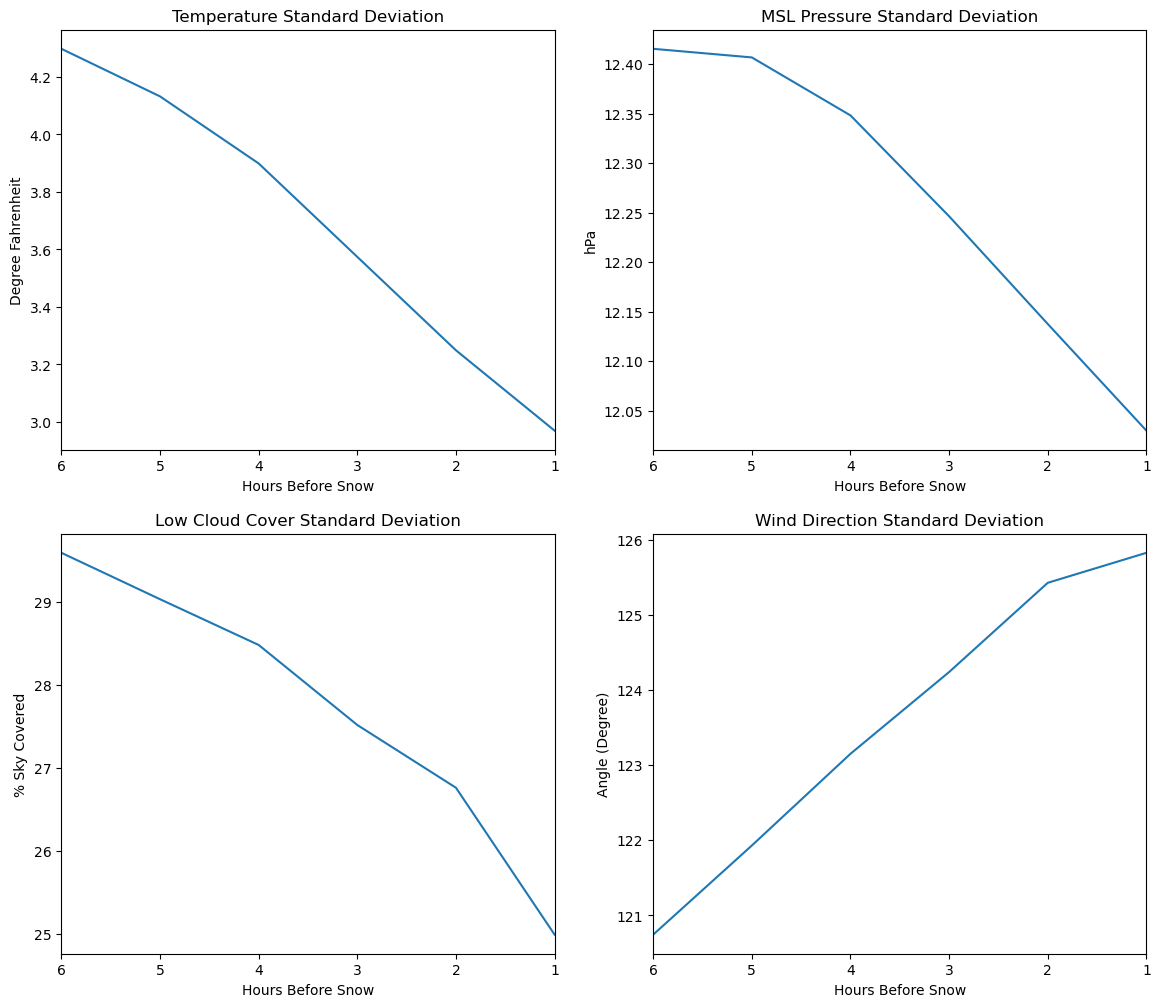

In [392]:
#plot the standard deviation of the temp, MSL pressure, cloud cover, and wind direction in the 6 hours before a snow-onset
plt.figure(figsize=(14,12))
plt.subplot(221)
plt.title("Temperature Standard Deviation")
plt.ylabel("Degree Fahrenheit")
plt.xlabel("Hours Before Snow")
plt.plot(hours, std_temp)
plt.xlim(6,1)

plt.subplot(222)
plt.title("MSL Pressure Standard Deviation")
plt.ylabel("hPa")
plt.xlabel("Hours Before Snow")
plt.plot(hours, std_pressure)
plt.xlim(6,1)

plt.subplot(223)
plt.title("Low Cloud Cover Standard Deviation")
plt.ylabel("% Sky Covered")
plt.xlabel("Hours Before Snow")
plt.plot(hours, std_cloud)
plt.xlim(6,1)

plt.subplot(224)
plt.title("Wind Direction Standard Deviation")
plt.ylabel("Angle (Degree)")
plt.xlabel("Hours Before Snow")
plt.plot(hours, std_wind)
plt.xlim(6,1)

Looking at the Mean, Median, and Standard Deviation plots, it appears that there are trends in Low Cloud Cover, Temperature, and MSL Pressure in the 6 hours preceeding snowfall. The temperature has a negative trend in the Mean graph but a positive trend in the Median graph, but since the change in the median is very small, I feel that the Mean trend is more accurate, meaning that the mean temperature increases as the time gets closer to a snowfall. The cloud cover and MSL pressure both have positive trends, meaning they increase as the time gets closer to a snowfall.

I feel confident in these 3 trends since their standard deviations all decrease as the time gets closer to a snowfall, meaning that there is less and less uncertainty about their mean values. However, the standard deviation for Wind Direction increases as the time gets closer to a snowfall, meaning that the mean (and thus the trend in the mean) is less and less certain. Therefore, I do not feel confident that the observed trend (negative then positive starting at 5 hours before snowfall) in the Wind Direction is a true trend.

Given that the Low Cloud Cover Mean's trend covers the largest range of values, I would say it would be fairly accurate in predicting snowfall. The other 2 trends cover a smaller range, but are still fairly steep trend-lines, making them semi-accurate as well. Thus, using the combination of all 3 variables, their prediction of snowfall is probably pretty accurate.